<a href="https://colab.research.google.com/github/ee17b031-iittp/DeepSAT-6-Satellite-Image-Classification/blob/master/deepsat_6_vgg_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $ Importing \, Dependencies $ #

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import xlrd
import pandas as pd
import scipy as sp
import io
from math import sqrt
from math import pi
from math import exp
from google.colab.patches import cv2_imshow
from sklearn.manifold import TSNE
import os
import glob
from sklearn.model_selection import StratifiedKFold
import scipy.io as sio
import plotly.graph_objects as go
from PIL import Image
# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve,f1_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage import data
import seaborn as sns; sns.set()

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.engine import Model
from keras import callbacks
from keras import optimizers
from keras.applications import vgg19 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,Activation
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import *
import tensorflow as tf

Using TensorFlow backend.


#$ Loading \, Dataset$#

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
file_path='/content/gdrive/My Drive/deepsat-sat6/'

In [ ]:
#importing_datasets
x_train = pd.read_csv(file_path+'X_train_sat6.csv',header=None) #This will kill the available memory on the kaggle machine :\
y_train = pd.read_csv(file_path+'y_train_sat6.csv',header=None)
x_train = x_train.values.reshape(x_train.shape[0],28,28,4).astype(np.float32)
y_train = y_train.values.astype(np.float32)

x_test = pd.read_csv(file_path+'X_test_sat6.csv',header=None)
y_test = pd.read_csv(file_path+'y_test_sat6.csv',header=None)
x_test = x_test.values.reshape(x_test.shape[0],28,28,4).astype(np.float32)
y_test = y_test.values.astype(np.float32)

# $Train-Val \, Split $

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

#$ Data \, Preprocessing$#

In [ ]:
dim=(32,32)
x_train =np.array([cv2.resize(x, dim, interpolation = cv2.INTER_AREA) for x in x_train])
x_val = np.array([cv2.resize(x, dim, interpolation = cv2.INTER_AREA) for x in x_val])
x_test = np.array([cv2.resize(x, dim, interpolation = cv2.INTER_AREA) for x in x_test])

In [ ]:
#not using the fourth channel-NIR
x_train=x_train[:,:,:,0:3]
x_val=x_val[:,:,:,0:3]
x_test=x_test[:,:,:,0:3]

In [ ]:
means=np.mean(x_train,axis=0)
x_train=(x_train-means)/255
x_test=(x_test-means)/255
x_val=(x_val-means)/255

#$Cyclic \, Learning \, Rate$#

In [ ]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """
 

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

#$ Learning \, Range \, Test $#
$ For \, completely \, freezed \, model \, (pre-trained \, layers) \, with \, an \, added \, classifier \, block$

In [ ]:
base_model = vgg.VGG19(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3))

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
last = base_model.get_layer('block5_pool').output

In [ ]:
last=GlobalAveragePooling2D()(last)
last=Dense(512,name='dense_top_1')(last)
x=BatchNormalization(name='batch_norm_top_1')(last)
x=Activation('relu',name='activation_top_1')(x)
x=Dense(256,name='dense_top_2')(x)
x=BatchNormalization(name='batch_norm_top_2')(x)
x=Activation('relu',name='activation_top_2')(x)
pred=Dense(6, activation='softmax',name='dense_top_3')(x)
new_model=Model(base_model.input,pred)

In [ ]:
for layer in base_model.layers:
     layer.trainable = False

In [ ]:
for layer in new_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f99e4bc0160> False
<keras.layers.convolutional.Conv2D object at 0x7f99e4c41d68> False
<keras.layers.convolutional.Conv2D object at 0x7f99e4c07ef0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f9a3be74908> False
<keras.layers.convolutional.Conv2D object at 0x7f9a84a939b0> False
<keras.layers.convolutional.Conv2D object at 0x7f99e4aa5eb8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f99e4abc518> False
<keras.layers.convolutional.Conv2D object at 0x7f99e4abc358> False
<keras.layers.convolutional.Conv2D object at 0x7f99e4abcf98> False
<keras.layers.convolutional.Conv2D object at 0x7f99e4a9fc50> False
<keras.layers.convolutional.Conv2D object at 0x7f99e4aca710> False
<keras.layers.pooling.MaxPooling2D object at 0x7f99e4acaf28> False
<keras.layers.convolutional.Conv2D object at 0x7f99e4acafd0> False
<keras.layers.convolutional.Conv2D object at 0x7f99e4ac0d30> False
<keras.layers.convolutional.Conv2D object at 0x7f99e4b2e908>

In [ ]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
clr = CyclicLR(base_lr=1e-6, max_lr=1e+1,
                        step_size=8*2295)

In [ ]:
history = new_model.fit(x_train,
                        y_train, 
                        batch_size=120, 
                        epochs=8,
                        validation_data=(x_val,y_val),
                        callbacks=[clr], 
                        verbose=1)

Train on 275400 samples, validate on 48600 samples
Epoch 1/8
275400/275400 [==============================] - 321s 1ms/step - loss: 0.4971 - accuracy: 0.8431 - val_loss: 1.2732 - val_accuracy: 0.4804
Epoch 2/8
275400/275400 [==============================] - 315s 1ms/step - loss: 1.5892 - accuracy: 0.4021 - val_loss: 1.5567 - val_accuracy: 0.3714
Epoch 3/8
275400/275400 [==============================] - 315s 1ms/step - loss: 1.6753 - accuracy: 0.3350 - val_loss: 1.6660 - val_accuracy: 0.3714
Epoch 4/8
275400/275400 [==============================] - 316s 1ms/step - loss: 1.6461 - accuracy: 0.3183 - val_loss: 1.6885 - val_accuracy: 0.3714
Epoch 5/8
275400/275400 [==============================] - 315s 1ms/step - loss: 2.1947 - accuracy: 0.3108 - val_loss: 1.7745 - val_accuracy: 0.2265
Epoch 6/8
275400/275400 [==============================] - 317s 1ms/step - loss: 2.4521 - accuracy: 0.3049 - val_loss: 1.5670 - val_accuracy: 0.3714
Epoch 7/8
275400/275400 [==============================

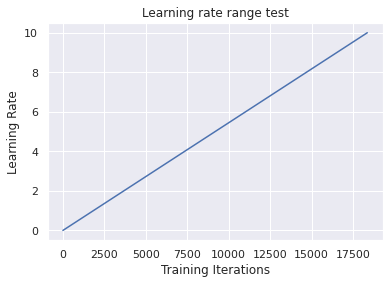

In [ ]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("Learning rate range test")
plt.plot(clr.history['iterations'], clr.history['lr'])

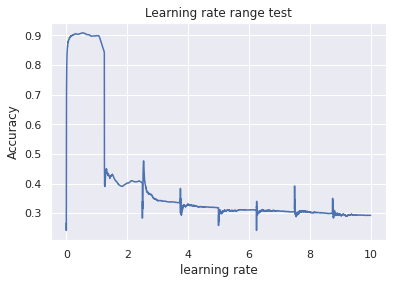

In [ ]:
h = clr.history
lr = h['lr']
acc = h['accuracy']
plt.xlabel('learning rate')
plt.ylabel('Accuracy')
plt.title("Learning rate range test")
plt.plot(lr,acc)

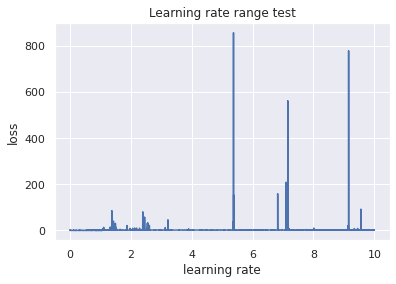

In [ ]:
loss=h['loss']
lr = h['lr']
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.title("Learning rate range test")
plt.plot(lr,loss)

In [ ]:
len(acc)

18360

In [ ]:
for i in range(5000):
  print(lr[i],acc[i])

Streaming output truncated to the last 5000 lines.
0.00054566225 0.24166666
0.0010903245 0.275
0.0016349867 0.36458334
0.002179649 0.43333334
0.0027243113 0.5
0.0032689734 0.54285717
0.0038136358 0.575
0.004358298 0.60462964
0.0049029603 0.63
0.0054476224 0.65378785
0.005992285 0.66805553
0.006536947 0.68333334
0.007081609 0.7011905
0.0076262713 0.7127778
0.008170933 0.72083336
0.008715596 0.7269608
0.009260259 0.73703706
0.00980492 0.74649125
0.010349583 0.75166667
0.0108942455 0.7563492
0.011438907 0.76325756
0.01198357 0.767029
0.012528232 0.7739583
0.013072894 0.7776667
0.013617557 0.7807692
0.014162218 0.78333336
0.014706881 0.7901786
0.015251543 0.7954023
0.015796205 0.79583335
0.016340869 0.8
0.01688553 0.8044271
0.017430192 0.80707073
0.017974854 0.8102941
0.018519517 0.8147619
0.019064179 0.81782407
0.01960884 0.8198198
0.020153504 0.82127196
0.020698166 0.8241453
0.021242827 0.825
0.02178749 0.82845527
0.022332152 0.830754
0.022876814 0.8313953
0.023421478 0.8333333
0.0239661

#$ Training \, the \, model $#
$ Here \, all \, the \, layers \, of \, the \, pretrained \, model \, are \, frozen$

In [ ]:
base_model = vgg.VGG19(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3))

In [ ]:
last = base_model.get_layer('block5_pool').output

In [ ]:
last=GlobalAveragePooling2D()(last)
last=Dense(512,name='dense_top_1')(last)
x=BatchNormalization(name='batch_norm_top_1')(last)
x=Activation('relu',name='activation_top_1')(x)
x=Dense(256,name='dense_top_2')(x)
x=BatchNormalization(name='batch_norm_top_2')(x)
x=Activation('relu',name='activation_top_2')(x)
pred=Dense(6, activation='softmax',name='dense_top_3')(x)
new_model=Model(base_model.input,pred)

In [ ]:
for layer in base_model.layers:
     layer.trainable = False

In [ ]:
for layer in new_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f99deaaf240> False
<keras.layers.convolutional.Conv2D object at 0x7f99deaaf860> False
<keras.layers.convolutional.Conv2D object at 0x7f99deaaf9e8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f99deaaf908> False
<keras.layers.convolutional.Conv2D object at 0x7f99deaafe80> False
<keras.layers.convolutional.Conv2D object at 0x7f99deaa4160> False
<keras.layers.pooling.MaxPooling2D object at 0x7f99deafe438> False
<keras.layers.convolutional.Conv2D object at 0x7f99deaf83c8> False
<keras.layers.convolutional.Conv2D object at 0x7f99deb06630> False
<keras.layers.convolutional.Conv2D object at 0x7f99deaa86d8> False
<keras.layers.convolutional.Conv2D object at 0x7f99deaa82b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f99deabf828> False
<keras.layers.convolutional.Conv2D object at 0x7f99deabf668> False
<keras.layers.convolutional.Conv2D object at 0x7f99deac2358> False
<keras.layers.convolutional.Conv2D object at 0x7f99deac2ef0>

In [ ]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
clr = CyclicLR(base_lr=0.61/4, max_lr=0.61,mode='triangular2',
                        step_size=2295)

Training using cyclical-learning-rate policy with parameters as mentioned above

In [ ]:
history = new_model.fit(x_train,
                    y_train,
                    batch_size=120,
                    epochs=20,
                    callbacks=[clr],
                    verbose=1,
                    validation_data=(x_val,y_val))

Train on 275400 samples, validate on 48600 samples
Epoch 1/20
275400/275400 [==============================] - 322s 1ms/step - loss: 0.2469 - accuracy: 0.9236 - val_loss: 0.7669 - val_accuracy: 0.8498
Epoch 2/20
275400/275400 [==============================] - 319s 1ms/step - loss: 0.1336 - accuracy: 0.9570 - val_loss: 0.1022 - val_accuracy: 0.9649
Epoch 3/20
275400/275400 [==============================] - 317s 1ms/step - loss: 0.1174 - accuracy: 0.9629 - val_loss: 0.4836 - val_accuracy: 0.8815
Epoch 4/20
275400/275400 [==============================] - 318s 1ms/step - loss: 0.1054 - accuracy: 0.9662 - val_loss: 0.0780 - val_accuracy: 0.9725
Epoch 5/20
275400/275400 [==============================] - 319s 1ms/step - loss: 0.0908 - accuracy: 0.9701 - val_loss: 0.2181 - val_accuracy: 0.9426
Epoch 6/20
275400/275400 [==============================] - 321s 1ms/step - loss: 0.1000 - accuracy: 0.9691 - val_loss: 0.0748 - val_accuracy: 0.9746
Epoch 7/20
275400/275400 [=======================

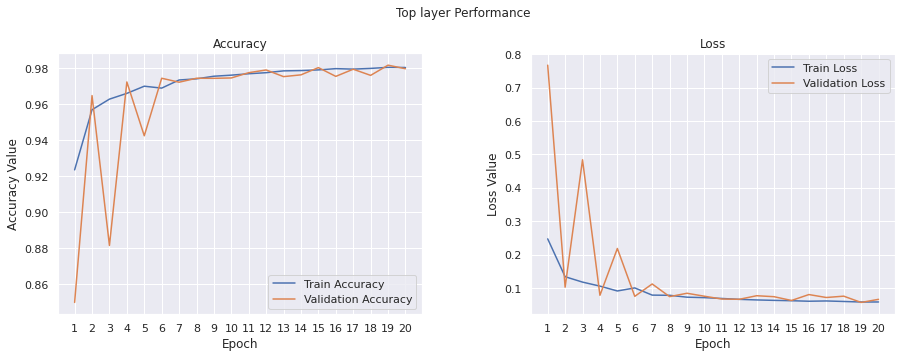

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Top layer Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,20+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Text(0, 0.5, 'Learning Rate')

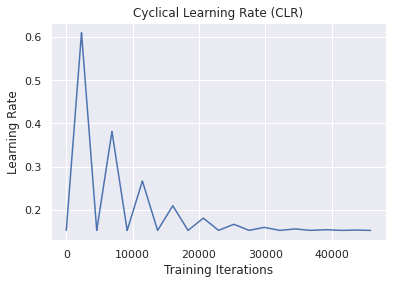

In [ ]:
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")

In [ ]:
new_model.save_weights('bottleneck_model_vgg_19.h5')

#$ Learning \, Range \, Test $#
$ Here \, some \, layers \, of \, the \, pre-trained \, model \, are \, set \, as \, trainable \, along \, with \, the \, classifier-block$

In [ ]:
final_base_model=(vgg.VGG19(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3)))

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
last = final_base_model.layers[-1].output

In [ ]:
last=GlobalAveragePooling2D()(last)
last=Dense(512,name='dense_top_1')(last)
x=BatchNormalization(name='batch_norm_top_1')(last)
x=Activation('relu',name='activation_top_1')(x)
x=Dense(256,name='dense_top_2')(x)
x=BatchNormalization(name='batch_norm_top_2')(x)
x=Activation('relu',name='activation_top_2')(x)
pred=Dense(6, activation='softmax',name='dense_top_3')(x)
final_model=Model(final_base_model.input,pred)

Loading the weights of the previously trained model

In [ ]:
final_model.load_weights('bottleneck_model_vgg_19.h5')

In [ ]:
final_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
for i in range(len(final_model.layers)-13):
  final_model.layers[i].trainable = False

In [ ]:
for layer in final_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f663f7490b8> False
<keras.layers.convolutional.Conv2D object at 0x7f663f736a90> False
<keras.layers.convolutional.Conv2D object at 0x7f663f736588> False
<keras.layers.pooling.MaxPooling2D object at 0x7f663f736ef0> False
<keras.layers.convolutional.Conv2D object at 0x7f663f736cf8> False
<keras.layers.convolutional.Conv2D object at 0x7f663f156f98> False
<keras.layers.pooling.MaxPooling2D object at 0x7f663f15a5f8> False
<keras.layers.convolutional.Conv2D object at 0x7f663f15a438> False
<keras.layers.convolutional.Conv2D object at 0x7f663f15af28> False
<keras.layers.convolutional.Conv2D object at 0x7f663f162cc0> False
<keras.layers.convolutional.Conv2D object at 0x7f663f169748> False
<keras.layers.pooling.MaxPooling2D object at 0x7f663f169f60> False
<keras.layers.convolutional.Conv2D object at 0x7f663f170278> False
<keras.layers.convolutional.Conv2D object at 0x7f663f170cf8> False
<keras.layers.convolutional.Conv2D object at 0x7f663f176898>

In [ ]:
final_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
final_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
clr = CyclicLR(base_lr=1e-8, max_lr=1,step_size=4*4590)

In [ ]:
history = final_model.fit(x_train,
                        y_train,
                        batch_size=60,
                        epochs=4,
                        verbose=1,
                        callbacks=[clr],
                        validation_data=(x_val,y_val))

Train on 275400 samples, validate on 48600 samples
Epoch 1/4
275400/275400 [==============================] - 744s 3ms/step - loss: 0.1761 - accuracy: 0.9428 - val_loss: 0.7568 - val_accuracy: 0.8390
Epoch 2/4
275400/275400 [==============================] - 736s 3ms/step - loss: 0.4406 - accuracy: 0.8696 - val_loss: 0.4801 - val_accuracy: 0.8290
Epoch 3/4
275400/275400 [==============================] - 734s 3ms/step - loss: 0.4293 - accuracy: 0.8661 - val_loss: 9.9757 - val_accuracy: 0.5041
Epoch 4/4
275400/275400 [==============================] - 739s 3ms/step - loss: 1.6683 - accuracy: 0.5289 - val_loss: nan - val_accuracy: 0.0460


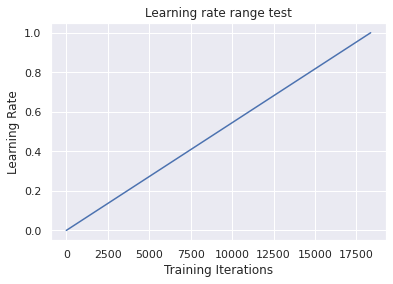

In [ ]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("Learning rate range test")
plt.plot(clr.history['iterations'], clr.history['lr'])

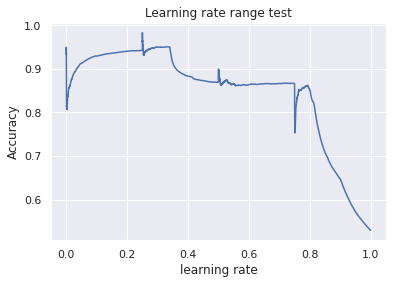

In [ ]:
h = clr.history
lr = h['lr']
acc = h['accuracy']
plt.xlabel('learning rate')
plt.ylabel('Accuracy')
plt.title("Learning rate range test")
plt.plot(lr,acc)

In [ ]:
len(acc)

18360

In [ ]:
for i in range(5000):
  print(lr[i],acc[i])

Streaming output truncated to the last 5000 lines.
5.447623e-05 0.95
0.00010894246 0.92777777
0.0001634087 0.9375
0.00021787493 0.9266667
0.00027234116 0.8972222
0.00032680738 0.89761907
0.00038127362 0.86875
0.00043573984 0.85555553
0.00049020606 0.8516667
0.0005446723 0.8469697
0.00059913856 0.84166664
0.00065360474 0.8346154
0.000708071 0.8297619
0.00076253724 0.81777775
0.0008170034 0.815625
0.0008714697 0.8156863
0.0009259359 0.8148148
0.0009804021 0.81754386
0.0010348684 0.8125
0.0010893346 0.815873
0.0011438008 0.81363636
0.0011982671 0.81449276
0.0012527333 0.8173611
0.0013071995 0.8146667
0.0013616658 0.81346154
0.001416132 0.8154321
0.0014705983 0.81785715
0.0015250645 0.81494254
0.0015795307 0.8161111
0.001633997 0.8172043
0.0016884631 0.815625
0.0017429293 0.8171717
0.0017973956 0.8147059
0.0018518618 0.8147619
0.001906328 0.8134259
0.0019607942 0.8117117
0.0020152605 0.81008774
0.0020697268 0.8094017
0.002124193 0.80875
0.0021786592 0.8081301
0.0022331255 0.8079365
0.00228

In [ ]:
for i in range(5000):
  print(lr[i+5000],acc[i+5000])

Streaming output truncated to the last 5000 lines.
0.27238563 0.9449029
0.2724401 0.9449556
0.27249455 0.9449678
0.27254903 0.9450201
0.27260348 0.9450721
0.27265796 0.945004
0.27271244 0.94485646
0.2727669 0.9449483
0.27282137 0.9450397
0.27287582 0.94501185
0.2729303 0.9449842
0.27298474 0.94491726
0.27303922 0.9449686
0.2730937 0.9449804
0.27314815 0.9447183
0.27320263 0.9448087
0.27325708 0.9448598
0.27331156 0.94491065
0.27336603 0.945
0.27342048 0.9450116
0.27347496 0.94498456
0.2735294 0.9450731
0.2735839 0.9451229
0.27363834 0.9451341
0.27369282 0.9451835
0.2737473 0.9451564
0.27380174 0.94520545
0.27385622 0.9452544
0.27391067 0.9452652
0.27396515 0.9452759
0.27401963 0.9453997
0.27407408 0.94548535
0.27412856 0.9456081
0.274183 0.94558054
0.27423748 0.94555306
0.27429193 0.9456003
0.2743464 0.94568455
0.2744009 0.94558275
0.27445534 0.9455926
0.27450982 0.94560236
0.27456427 0.94564897
0.27461874 0.94565856
0.27467322 0.94563144
0.27472767 0.9457143
0.27478215 0.9458333
0.274

#$ Training \, the \, model $#
$ Here \, some \, layers \, of \, the \, pre-trained \, model \, are \, set \, as \, trainable \, along \, with \, the \, classifier-block$

In [ ]:
final_base_model=(vgg.VGG19(weights='imagenet', 
                       include_top=False, 
                       input_shape=(32, 32, 3)))

In [ ]:
last = final_base_model.layers[-1].output

In [ ]:
last=GlobalAveragePooling2D()(last)
last=Dense(512,name='dense_top_1')(last)
x=BatchNormalization(name='batch_norm_top_1')(last)
x=Activation('relu',name='activation_top_1')(x)
x=Dense(256,name='dense_top_2')(x)
x=BatchNormalization(name='batch_norm_top_2')(x)
x=Activation('relu',name='activation_top_2')(x)
pred=Dense(6, activation='softmax',name='dense_top_3')(x)
final_model=Model(final_base_model.input,pred)

In [ ]:
final_model.load_weights('bottleneck_model_vgg_19.h5')

In [ ]:
for i in range(len(final_model.layers)-13):
  final_model.layers[i].trainable = False

In [ ]:
for layer in final_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa2d9c71b38> False
<keras.layers.convolutional.Conv2D object at 0x7fa2d9c71c18> False
<keras.layers.convolutional.Conv2D object at 0x7fa2d9c71e10> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa2d9d24b70> False
<keras.layers.convolutional.Conv2D object at 0x7fa2d9a28ef0> False
<keras.layers.convolutional.Conv2D object at 0x7fa2c16a44a8> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa2bfa54940> False
<keras.layers.convolutional.Conv2D object at 0x7fa2bfa54780> False
<keras.layers.convolutional.Conv2D object at 0x7fa2bfa583c8> False
<keras.layers.convolutional.Conv2D object at 0x7fa2bfa58fd0> False
<keras.layers.convolutional.Conv2D object at 0x7fa2bfa66a90> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa2bfa6c518> False
<keras.layers.convolutional.Conv2D object at 0x7fa2bfa6c358> False
<keras.layers.convolutional.Conv2D object at 0x7fa2bfa6cf60> False
<keras.layers.convolutional.Conv2D object at 0x7fa2bfa70be0>

In [ ]:
final_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
final_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
clr = CyclicLR(base_lr=(0.3307/5), max_lr=0.33307,step_size=4950,mode='triangular2')

In [ ]:
checkpointer = ModelCheckpoint(monitor='val_loss',filepath='final_model.weights.best.hdf5', verbose = 1, save_best_only=True)

Training using cyclical-learning-rate using the parameters as mentioned above

In [ ]:
history = final_model.fit(x_train,
                        y_train,
                        batch_size=60,
                        epochs=10,
                        verbose=1,
                        callbacks=[clr,checkpointer],
                        validation_data=(x_val,y_val))

Train on 275400 samples, validate on 48600 samples
Epoch 1/10
275400/275400 [==============================] - 812s 3ms/step - loss: 0.1830 - accuracy: 0.9431 - val_loss: 0.7374 - val_accuracy: 0.8387

Epoch 00001: val_loss improved from inf to 0.73740, saving model to final_model.weights.best.hdf5
Epoch 2/10
275400/275400 [==============================] - 818s 3ms/step - loss: 0.1166 - accuracy: 0.9642 - val_loss: 0.0978 - val_accuracy: 0.9646

Epoch 00002: val_loss improved from 0.73740 to 0.09783, saving model to final_model.weights.best.hdf5
Epoch 3/10
275400/275400 [==============================] - 817s 3ms/step - loss: 0.0735 - accuracy: 0.9757 - val_loss: 0.2626 - val_accuracy: 0.9157

Epoch 00003: val_loss did not improve from 0.09783
Epoch 4/10
275400/275400 [==============================] - 818s 3ms/step - loss: 0.0774 - accuracy: 0.9757 - val_loss: 0.1285 - val_accuracy: 0.9544

Epoch 00004: val_loss did not improve from 0.09783
Epoch 5/10
275400/275400 [=================

In [ ]:
final_model.load_weights('final_model.weights.best.hdf5')

Text(0, 0.5, 'Learning Rate')

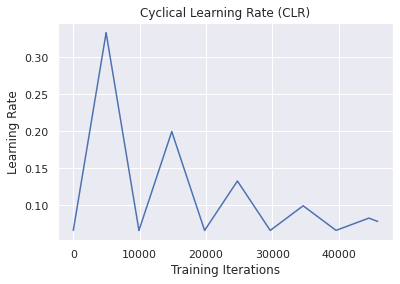

In [ ]:
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")

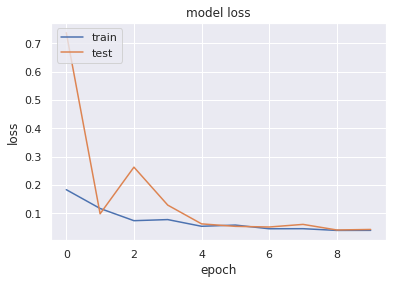

In [ ]:
# plotting training and cross-validation loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

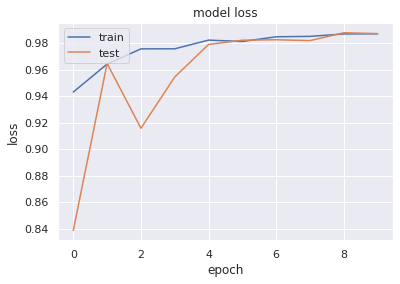

In [ ]:
# plotting training and cross-validation loss curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#$Testing \, the \, model$

In [ ]:
print("test accuracy = ",final_model.evaluate(x_test,y_test))
y_pred_class = final_model.predict(x_test, verbose=0)

81000/81000 [==============================] - 112s 1ms/step
test accuracy =  [0.04052618079038082, 0.9872345924377441]


In [ ]:
print('f1_score =',f1_score(np.argmax(y_test,axis=-1),np.argmax(y_pred_class,axis=-1),average='weighted'))

f1_score = 0.9872554311947523


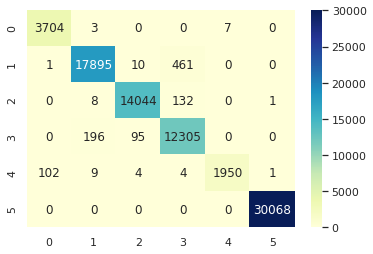

In [ ]:
cm=confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_pred_class,axis=-1))
fig = go.Figure(data=[go.Table(header=dict(values=['Confusion Matrix ','1','2','3','4','5','6']),
                 cells=dict(values=[['predicted as 1','predicted as 2','predicted as 3','predicted as 4','predicted as 5',
                                     'predicted as 6'],cm[0,:],cm[1,:],cm[2,:],cm[3,:],
                                    cm[4,:],cm[5,:]]))])
fig.show()
ax = sns.heatmap(cm, annot=True,cmap="YlGnBu", fmt="d")

In [ ]:
label_names=['barren land', 'trees', 'grassland', 'roads', 'buildings', 'water bodies']
print(classification_report(np.argmax(y_test,axis=-1),np.argmax(y_pred_class,axis=-1),
	target_names=label_names))

              precision    recall  f1-score   support

 barren land       0.97      1.00      0.98      3714
       trees       0.99      0.97      0.98     18367
   grassland       0.99      0.99      0.99     14185
       roads       0.95      0.98      0.97     12596
   buildings       1.00      0.94      0.97      2070
water bodies       1.00      1.00      1.00     30068

    accuracy                           0.99     81000
   macro avg       0.98      0.98      0.98     81000
weighted avg       0.99      0.99      0.99     81000

